# Imports and set up

In [72]:
!pip install biopython

In [73]:
!pip install PyBioMed

In [403]:
!pip install --upgrade shap-hypetune

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.6/538.6 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 35.3 MB/s eta 0:00:00


In [455]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 6.5 MB/s eta 0:00:00


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic data preprocessing

In [75]:
raw_df = pd.read_csv('data_preprocessed.csv')

#Encoder for Type of Nucleic Acid
''' {"2',4'-BNA/LNA-DNA": 0, "2'-O-Me-RNA": 1, "2'-amino-RNA": 2,
"2'-fluoro-RNA": 3, "2'-fluoro/O-Me-RNA": 4, "2'-fluoro/amino-RNA": 5,
"4'-thio-RNA": 6, '5-uracil-modified-DNA': 7, '5-uracil-modified-RNA': 8,
'FANA XNA': 9, 'dsDNA': 10, 'ssDNA': 11, 'ssRNA': 12}'''

# Encoder for Type of the buffer
#{'Not Reported': 0, 'Other Buffers': 1, 'PBS/phosphate buffers': 2, 'Tris Buffers': 3, nan: 4}

# Отфильтровываем строки в которых представлены данные по dsDNA
df = raw_df[raw_df['Type of Nucleic Acid'] == 11]
print(f'Осталось {len(df)} из {len(raw_df)}')

Осталось 450 из 751


In [221]:
# Очистка от ДНК последовательностей с неправильными буквами
df = df[~df['Aptamer Sequence'].str.contains('S')]
df = df[~df['Aptamer Sequence'].str.contains('P')]
len(df)

446

In [222]:
# В некоторых последовательностях (всего в 2) содержится X - пропущенные аминокислоты, поэтому мы его просто удаляем

df = df[~df['filtered_sequence'].str.contains('X')]

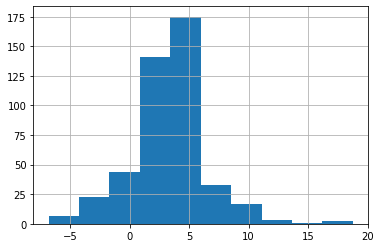

In [223]:
df['log_Kd'] = np.log(df['Kd (nM)'])
df['log_Kd'].hist()
plt.show()

# Дескрипторы и их EDA

### Дескрипторы белка BioPython

In [318]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [319]:
def calculate_protein_descriptors(sequence):
    analysis = ProteinAnalysis(sequence)
    
    descriptors = {
        'molecular_weight': analysis.molecular_weight(),
        'aromaticity': analysis.aromaticity(),
        'instability_index': analysis.instability_index(),
        'isoelectric_point': analysis.isoelectric_point(),
        'helix_fraction': analysis.secondary_structure_fraction()[0],
        'turn_fraction': analysis.secondary_structure_fraction()[1],
        'sheet_fraction': analysis.secondary_structure_fraction()[2],
        'molar_extinction_coefficient_reduced': analysis.molar_extinction_coefficient()[0],
        'molar_extinction_coefficient_oxidized': analysis.molar_extinction_coefficient()[1],
        'gravy': analysis.gravy(),
        'filtered_sequence':sequence
        
       
    }
    
    return pd.Series(descriptors)

In [320]:
df_descriptors = df['filtered_sequence'].apply(calculate_protein_descriptors)

In [321]:
def calculate_charge_at_pH(row):
    analysis = ProteinAnalysis(row['filtered_sequence'])
    ph = row['pH']
    return analysis.charge_at_pH(ph)

In [323]:
df_descriptors['charge_at_ph'] = df.apply(lambda row: calculate_charge_at_pH(row), axis=1)
df_descriptors.head()

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,filtered_sequence,charge_at_ph
3,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521
4,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521
46,20712.8120,0.047368,46.075316,9.605870,0.252632,0.300000,0.384211,2980,3230,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,7.075591
47,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,0.350380,261610,262860,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514
48,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,0.350380,261610,262860,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514


In [324]:
df_descriptors_merged = pd.merge(df_descriptors, df.copy(), on='filtered_sequence')
df_descriptors_merged.head()

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,sheet_fraction,molar_extinction_coefficient_reduced,molar_extinction_coefficient_oxidized,gravy,filtered_sequence,charge_at_ph,Type of Nucleic Acid,Aptamer Sequence,Sequence Length,GC Content,Kd (nM),Type of the buffer,pH,log_Kd
0,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,11,GGTTGGTGTGGTTGG,15,0.600000,112.5,3,7.4,4.722953
1,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,11,GGTTGG,6,0.666667,112.5,3,7.4,4.722953
2,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,11,GGTTGGTGTGGTTGG,15,0.600000,112.5,3,7.4,4.722953
3,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,0.357143,65890,66390,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,11,GGTTGG,6,0.666667,112.5,3,7.4,4.722953
4,20712.8120,0.047368,46.075316,9.605870,0.252632,0.300000,0.384211,2980,3230,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,7.075591,11,CTACCTGGGGGAGCATTGGGGAGGAAGGTAGCCGTGCGAAAA,42,0.595238,6000.0,3,7.6,8.699515


In [325]:
def draw_heatmap(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                linewidths=.5, cbar_kws={"shrink": .8}, square=True)

    # Add title and adjust layout
    plt.title('Correlation Heatmap of df_descriptors', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Show the heatmap
    plt.show()

<ipython-input-325-5d13b702f969>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


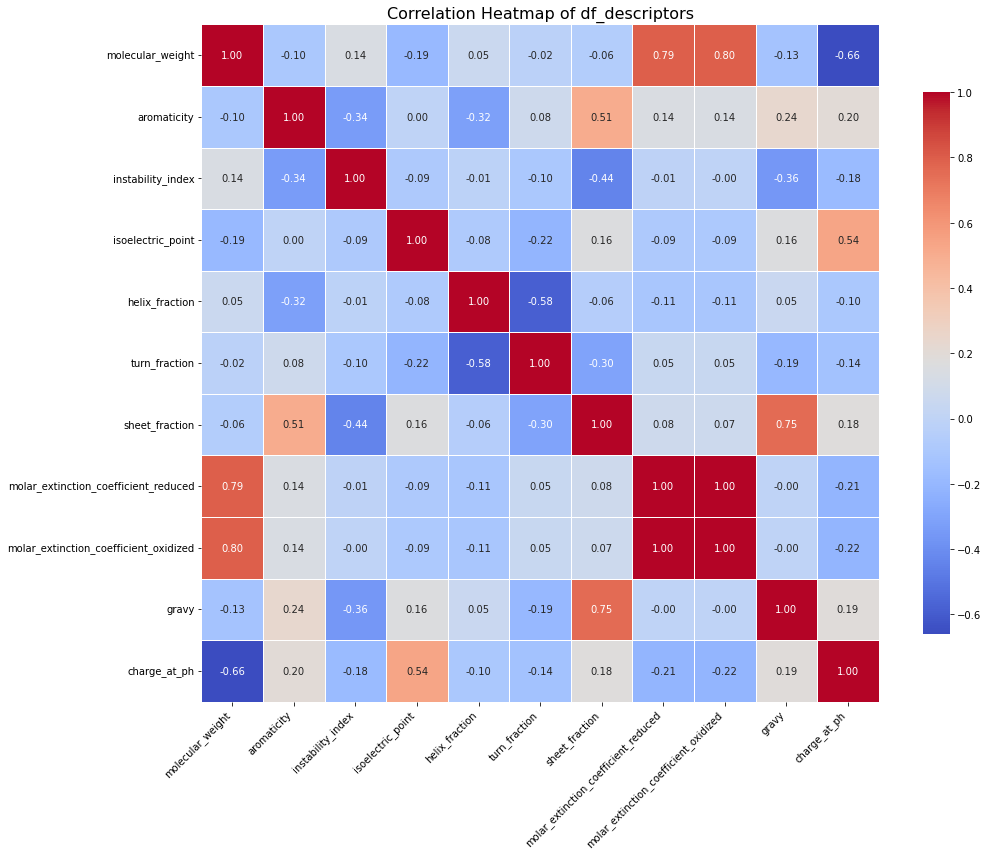

In [326]:
draw_heatmap(df_descriptors)

In [327]:
def identify_correlations(df, strong_threshold=0.75, moderate_threshold=0.5):
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Create a mask to ignore self-correlations (diagonal)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Apply the mask
    corr_matrix_masked = corr_matrix.mask(mask)

    # Identify strong positive correlations
    strong_positive = corr_matrix_masked[(corr_matrix_masked >= strong_threshold)]
    
    # Identify strong negative correlations
    strong_negative = corr_matrix_masked[(corr_matrix_masked <= -strong_threshold)]

    # Identify moderate positive correlations
    moderate_positive = corr_matrix_masked[(corr_matrix_masked >= moderate_threshold) & 
                                           (corr_matrix_masked < strong_threshold)]
    
    # Identify moderate negative correlations
    moderate_negative = corr_matrix_masked[(corr_matrix_masked <= -moderate_threshold) & 
                                           (corr_matrix_masked > -strong_threshold)]

    # Print strong positive correlations
    print("Strong Positive Correlations (Threshold: {}):".format(strong_threshold))
    for row in strong_positive.index:
        for col in strong_positive.columns:
            if pd.notna(strong_positive.loc[row, col]):
                print(f"{row} and {col}: {strong_positive.loc[row, col]:.2f}")

    print('---')
    
    # Print strong negative correlations
    print("\nStrong Negative Correlations (Threshold: {}):".format(strong_threshold))
    for row in strong_negative.index:
        for col in strong_negative.columns:
            if pd.notna(strong_negative.loc[row, col]):
                print(f"{row} and {col}: {strong_negative.loc[row, col]:.2f}")

    # Print moderate positive correlations
    print("\nModerate Positive Correlations (Threshold: {}):".format(moderate_threshold))
    for row in moderate_positive.index:
        for col in moderate_positive.columns:
            if pd.notna(moderate_positive.loc[row, col]):
                print(f"{row} and {col}: {moderate_positive.loc[row, col]:.2f}")

    print('---')
    
    # Print moderate negative correlations
    print("\nModerate Negative Correlations (Threshold: {}):".format(moderate_threshold))
    for row in moderate_negative.index:
        for col in moderate_negative.columns:
            if pd.notna(moderate_negative.loc[row, col]):
                print(f"{row} and {col}: {moderate_negative.loc[row, col]:.2f}")

    print('---')

In [328]:
identify_correlations(df_descriptors)

Strong Positive Correlations (Threshold: 0.75):
molar_extinction_coefficient_reduced and molecular_weight: 0.79
molar_extinction_coefficient_oxidized and molecular_weight: 0.80
molar_extinction_coefficient_oxidized and molar_extinction_coefficient_reduced: 1.00
gravy and sheet_fraction: 0.75
---

Strong Negative Correlations (Threshold: 0.75):

Moderate Positive Correlations (Threshold: 0.5):
sheet_fraction and aromaticity: 0.51
charge_at_ph and isoelectric_point: 0.54
---

Moderate Negative Correlations (Threshold: 0.5):
turn_fraction and helix_fraction: -0.58
charge_at_ph and molecular_weight: -0.66
---


<ipython-input-327-891eae6716ea>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


**Выводы из корреляций:**

- По коэффициентам корелляции можно сделать следующий вывод: чем больше частица, тем лучше происходит поглощение света, а значит больше молярная экстинкция, данная корелляция очевидна
- Что касается второй строчки,молярный коэффициент поглощения (также известный как молярная поглощательная способность) является показателем того, насколько сильно вещество поглощает свет на определенной длине волны. Второй параметр, это, по сути, то же самое.Тут тоже происходит поглощение на разных длинах волн (на окисленной и восстановленной формах).Поэтому между этими параметрами очень сильная корелляция
- Параметр gravy является мерой гидрофобности белка.Бета-листы в белках обычно характеризуются тем, что аминокислоты, образующие их структуру, имеют гидрофобные свойства. Поэтому здесь достаточно сильная корелляция
- Бета-листы, как правило, гидрофобны.Ароматические кольца могут участвовать в гидрофобных взаимодействиях, которые способствуют свертыванию белка и его стабилизации. Поэтому здесь прослеживается не слишком сильная корелляция.
- Первый параметр показывает долю петель в белке, второй- долю альфа-спиралей.На образование петель и спиралей нужно пространство.Отсюда, чем больше петель, тем меньше альфа-спиралей может образоваться.Здесь мы наблюдаем обратную корелляцию

In [329]:
df_descriptors_filtered=df_descriptors.drop(['molar_extinction_coefficient_reduced', 'molar_extinction_coefficient_oxidized', 'sheet_fraction'], axis=1)
df_descriptors_filtered

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,filtered_sequence,charge_at_ph
3,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521
4,35436.1942,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521
46,20712.8120,0.047368,46.075316,9.605870,0.252632,0.300000,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,7.075591
47,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514
48,163286.4207,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514
...,...,...,...,...,...,...,...,...,...
728,53651.0423,0.051502,58.075751,5.063468,0.375536,0.253219,-0.823176,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,-19.531950
730,92461.9469,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718
731,92461.9469,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718
747,117530.2268,0.068738,50.059520,6.400377,0.305085,0.283427,-0.364218,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-9.317211


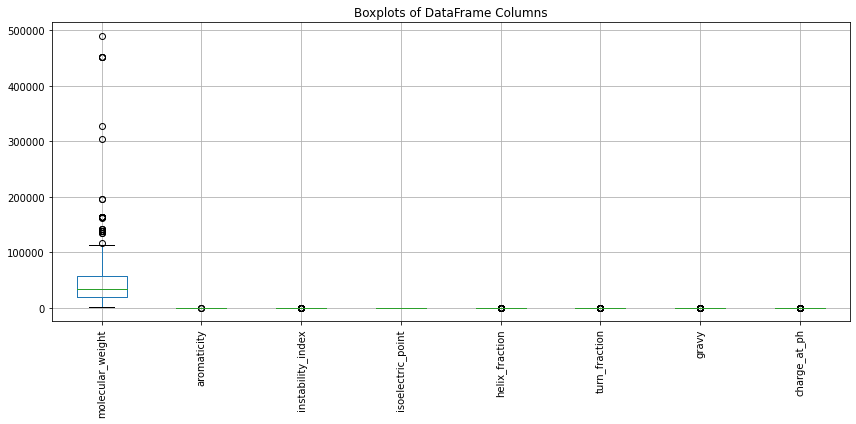

In [330]:
def plot_boxplots(df):
    plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
    df.boxplot()  # Строим боксплоты для всех столбцов датафрейма
    plt.xticks(rotation=90)  # Поворачиваем подписи по оси X, чтобы они не перекрывались
    plt.title('Boxplots of DataFrame Columns')  # Устанавливаем заголовок графика
    plt.grid(True)  # Включаем сетку
    plt.tight_layout()  # Улучшаем отображение графика

    plt.show()  # Отображаем график
    
plot_boxplots(df_descriptors_filtered.drop('filtered_sequence', axis=1))

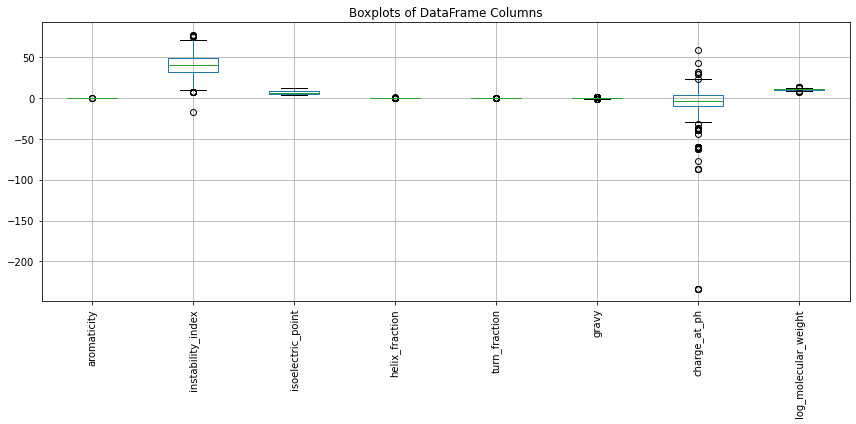

In [331]:
df_descriptors_filtered['log_molecular_weight'] = np.log(df_descriptors_filtered['molecular_weight'])
df_descriptors_filtered = df_descriptors_filtered.drop('molecular_weight', axis=1)
plot_boxplots(df_descriptors_filtered.drop('filtered_sequence', axis=1))

### Дескрипторы ДНК PyBioMed

In [332]:
#Дескрипторы для белков
#дескрипторы CTD описывают долю аминокислот с определенными химическими свойствами (C), 
#а также корреляцию между аминокислотами с разными химическими свойствами (T) 
from PyBioMed.PyProtein import CTD

def pybiomed_proteinCT(seq):
    a = CTD.CalculateC(seq)
    b = CTD.CalculateT(seq)
    a.update(b)
    return a

new_cols = list(pybiomed_proteinCT('AAA').keys())
def pybiomed_proteinCT2(seq):
    a = CTD.CalculateC(seq)
    b = CTD.CalculateT(seq)
    a.update(b)
    return [seq]+list(a.values())

len(pybiomed_proteinCT2('AAA'))
pybiomed_df = df.copy()

prottups = pybiomed_df['filtered_sequence'].apply(pybiomed_proteinCT2)
pybiomed_prot_df = pd.DataFrame(prottups.to_list(), columns=['filtered_sequence']+new_cols)
pybiomed_prot_df

,filtered_sequence,_PolarizabilityC1,_PolarizabilityC2,_PolarizabilityC3,_SolventAccessibilityC1,_SolventAccessibilityC2,_SolventAccessibilityC3,_SecondaryStrC1,_SecondaryStrC2,_SecondaryStrC3,...,_ChargeT23,_PolarityT12,_PolarityT13,_PolarityT23,_NormalizedVDWVT12,_NormalizedVDWVT13,_NormalizedVDWVT23,_HydrophobicityT12,_HydrophobicityT13,_HydrophobicityT23
0,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,0.286,0.419,0.295,0.429,0.347,0.224,0.429,0.295,0.276,...,0.189,0.153,0.124,0.072,0.199,0.202,0.218,0.212,0.218,0.205
1,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,0.286,0.419,0.295,0.429,0.347,0.224,0.429,0.295,0.276,...,0.189,0.153,0.124,0.072,0.199,0.202,0.218,0.212,0.218,0.205
2,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,0.300,0.489,0.211,0.458,0.300,0.242,0.389,0.311,0.300,...,0.143,0.143,0.085,0.069,0.296,0.132,0.190,0.185,0.201,0.259
3,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.290,0.461,0.249,0.416,0.357,0.227,0.456,0.288,0.256,...,0.170,0.159,0.104,0.071,0.270,0.158,0.202,0.233,0.227,0.205
4,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,0.290,0.461,0.249,0.416,0.357,0.227,0.456,0.288,0.256,...,0.170,0.159,0.104,0.071,0.270,0.158,0.202,0.233,0.227,0.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,0.309,0.466,0.225,0.333,0.440,0.227,0.552,0.195,0.253,...,0.260,0.176,0.108,0.067,0.280,0.140,0.198,0.234,0.288,0.157
442,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,0.286,0.446,0.268,0.410,0.334,0.256,0.425,0.288,0.287,...,0.193,0.155,0.088,0.053,0.275,0.195,0.213,0.231,0.214,0.231
443,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,0.286,0.446,0.268,0.410,0.334,0.256,0.425,0.288,0.287,...,0.193,0.155,0.088,0.053,0.275,0.195,0.213,0.231,0.214,0.231
444,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,0.317,0.463,0.219,0.428,0.312,0.260,0.458,0.259,0.283,...,0.162,0.130,0.097,0.065,0.305,0.148,0.172,0.247,0.178,0.230


In [333]:
identify_correlations(pybiomed_prot_df)

Strong Positive Correlations (Threshold: 0.75):
_ChargeC3 and _SolventAccessibilityC2: 0.81
_PolarityC3 and _ChargeC1: 0.95
_NormalizedVDWVC1 and _PolarizabilityC1: 0.91
_NormalizedVDWVC3 and _PolarizabilityC3: 1.00
_HydrophobicityC1 and _SolventAccessibilityC2: 1.00
_HydrophobicityC1 and _ChargeC3: 0.81
_HydrophobicityC2 and _PolarizabilityC1: 0.80
_HydrophobicityC2 and _NormalizedVDWVC1: 0.93
_HydrophobicityC3 and _PolarityC1: 0.97
_SolventAccessibilityT13 and _ChargeC2: 0.78
_ChargeT12 and _ChargeC1: 0.92
_ChargeT12 and _PolarityC3: 0.87
_ChargeT23 and _ChargeC3: 0.94
_PolarityT23 and _SolventAccessibilityC2: 0.79
_PolarityT23 and _HydrophobicityC1: 0.79
_NormalizedVDWVT12 and _PolarizabilityT12: 0.76
_NormalizedVDWVT13 and _PolarizabilityT13: 0.93
_NormalizedVDWVT23 and _PolarizabilityT23: 0.86
_HydrophobicityT23 and _SolventAccessibilityC1: 0.79
_HydrophobicityT23 and _ChargeC2: 0.77
---

Strong Negative Correlations (Threshold: 0.75):
_SolventAccessibilityC2 and _SolventAccessibi

<ipython-input-327-891eae6716ea>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


In [334]:
def corr_deler(df):
    ans = []
    corr_matrix = df.corr(method='pearson')
# Loop over bottom diagonal of correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.75:
                #print(corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                ans.append(corr_matrix.columns[i])
    
    return list(set(ans))
                
to_del = corr_deler(pybiomed_prot_df)
print(len(to_del))
pybiomed_prot_df = pybiomed_prot_df.drop(to_del, axis=1)
pybiomed_prot_df.head(1)

23


<ipython-input-334-1437801ae7bb>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method='pearson')


,filtered_sequence,_PolarizabilityC1,_PolarizabilityC2,_PolarizabilityC3,_SolventAccessibilityC1,_SolventAccessibilityC3,_SecondaryStrC1,_SecondaryStrC2,_SecondaryStrC3,_ChargeC1,_PolarityC1,_PolarityC2,_NormalizedVDWVC2,_PolarizabilityT12,_SolventAccessibilityT12,_SecondaryStrT12,_SecondaryStrT13,_PolarityT12,_PolarityT13,_HydrophobicityT13
0,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,0.286,0.419,0.295,0.429,0.224,0.429,0.295,0.276,0.149,0.354,0.188,0.341,0.212,0.3,0.257,0.257,0.153,0.124,0.218


<ipython-input-325-5d13b702f969>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


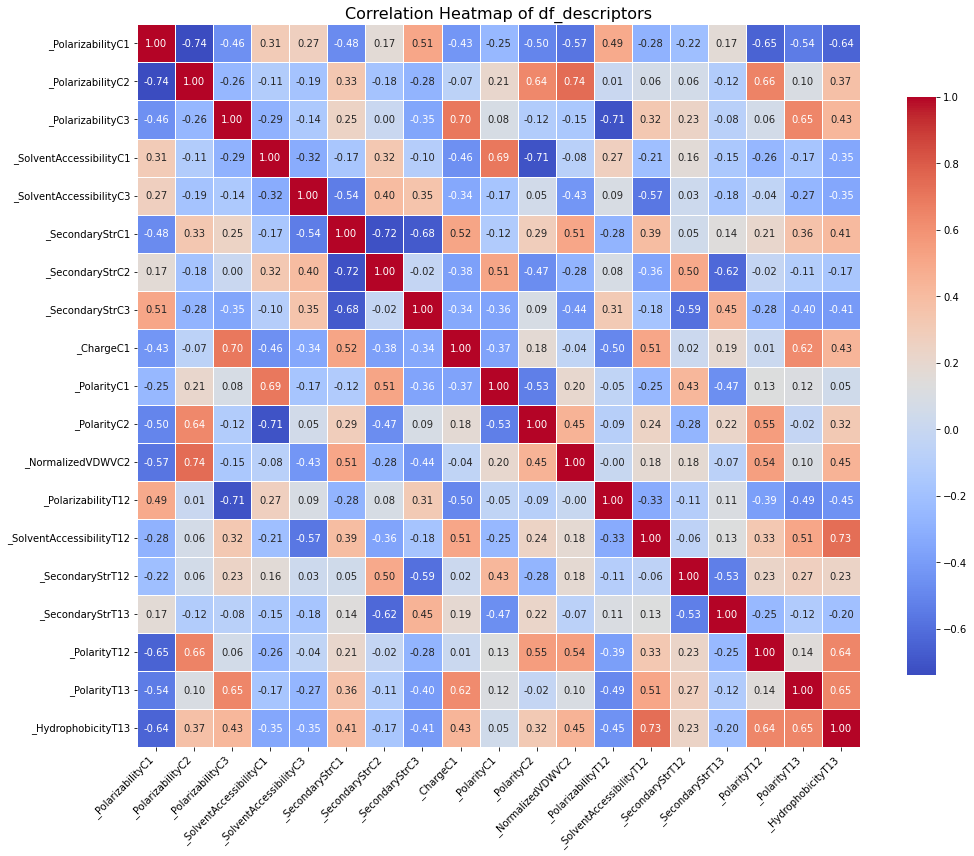

In [335]:
draw_heatmap(pybiomed_prot_df)

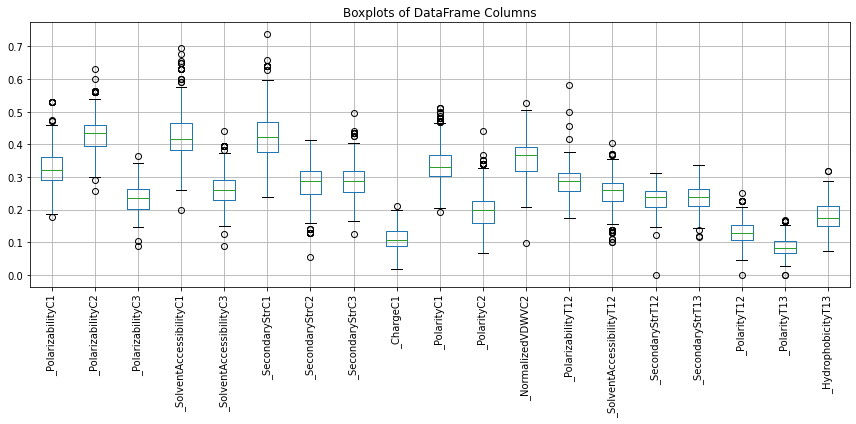

In [336]:
plot_boxplots(pybiomed_prot_df)

In [337]:
#Дескрипторы корреляций оснований днк с разными физико-химическими свойствами  
from PyBioMed.PyDNA.PyDNAac import GetDAC

def pybiomed_dac(seq):
    a = GetDAC(seq, all_property=True)
    return a

new_colsdna = list(pybiomed_dac('AATTTTA').keys())
def pybiomed_dac2(seq):
    a = GetDAC(seq, all_property=True)
    return [seq]+list(a.values())

#len(pybiomed_dac('AATTTTA'))
pybiomed_df2 = df.copy()

dnatups = pybiomed_df2['Aptamer Sequence'].apply(pybiomed_dac2)
pybiomed_dna_df = pd.DataFrame(dnatups.to_list(), columns=['Aptamer Sequence']+new_colsdna)
pybiomed_dna_df.head(1)

,Aptamer Sequence,DAC_1,DAC_2,DAC_3,DAC_4,DAC_5,DAC_6,DAC_7,DAC_8,DAC_9,...,DAC_67,DAC_68,DAC_69,DAC_70,DAC_71,DAC_72,DAC_73,DAC_74,DAC_75,DAC_76
0,GGTTGGTGTGGTTGG,-0.17,-0.333,-0.09,-0.01,-0.379,-0.08,-0.042,-0.282,-0.235,...,-0.281,-0.223,-0.188,-0.635,-0.333,0.047,-0.213,0.261,-0.168,-0.221


In [338]:
to_del2 = corr_deler(pybiomed_dna_df)
print(len(to_del2))
pybiomed_dna_df = pybiomed_dna_df.drop(to_del2, axis=1)
pybiomed_dna_df.head(1)

48


<ipython-input-334-1437801ae7bb>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method='pearson')


,Aptamer Sequence,DAC_1,DAC_2,DAC_3,DAC_4,DAC_5,DAC_6,DAC_11,DAC_13,DAC_26,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
0,GGTTGGTGTGGTTGG,-0.17,-0.333,-0.09,-0.01,-0.379,-0.08,-0.302,-0.158,-0.25,...,-0.81,-0.268,0.183,-0.146,0.194,-0.206,0.047,-0.213,0.261,-0.168


<ipython-input-325-5d13b702f969>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


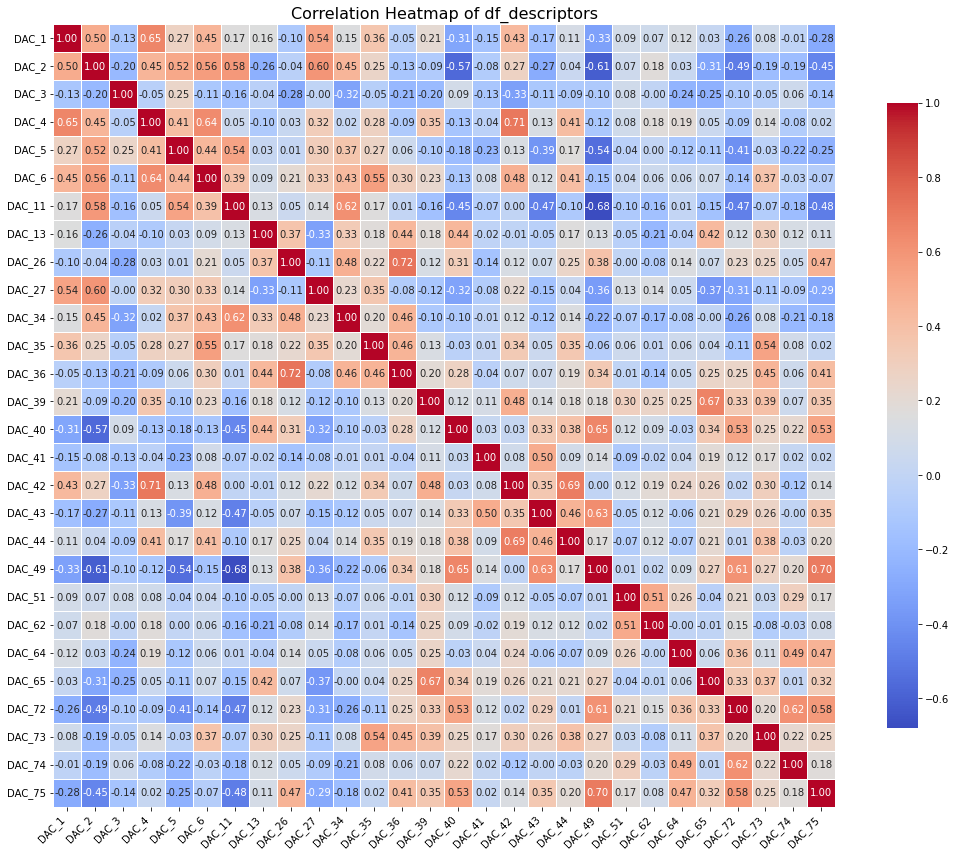

In [339]:
draw_heatmap(pybiomed_dna_df)

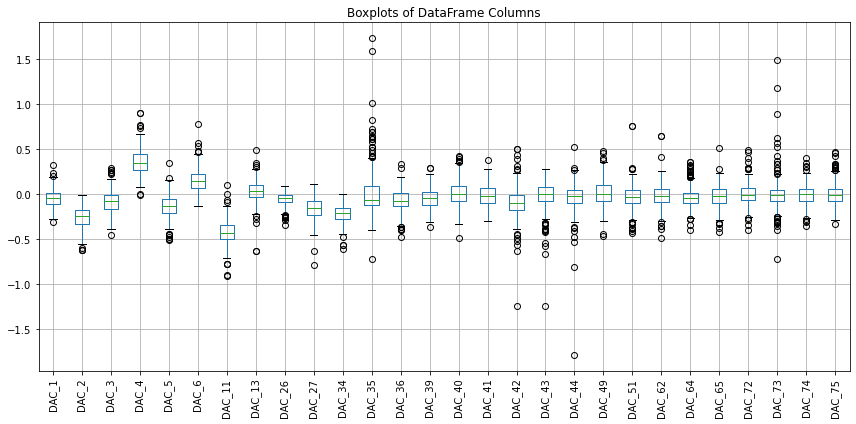

In [340]:
plot_boxplots(pybiomed_dna_df.drop('Aptamer Sequence', axis=1))

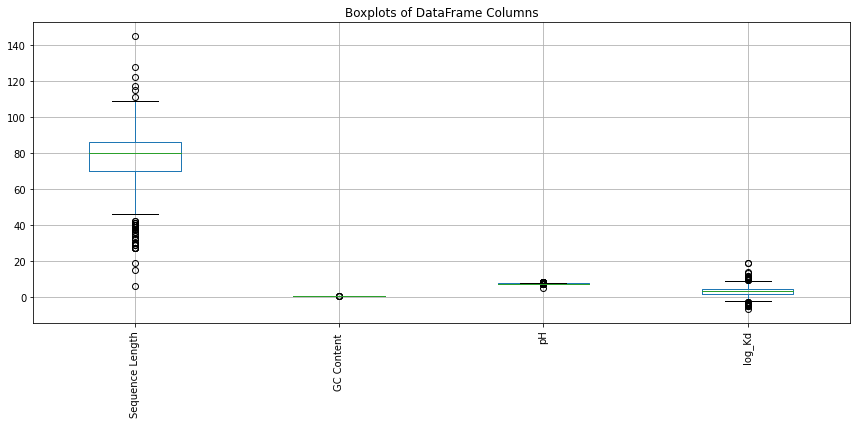

In [341]:
plot_boxplots(df.drop(['Type of Nucleic Acid', 'Aptamer Sequence', 'Kd (nM)', 'Type of the buffer'], axis=1))

<ipython-input-325-5d13b702f969>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


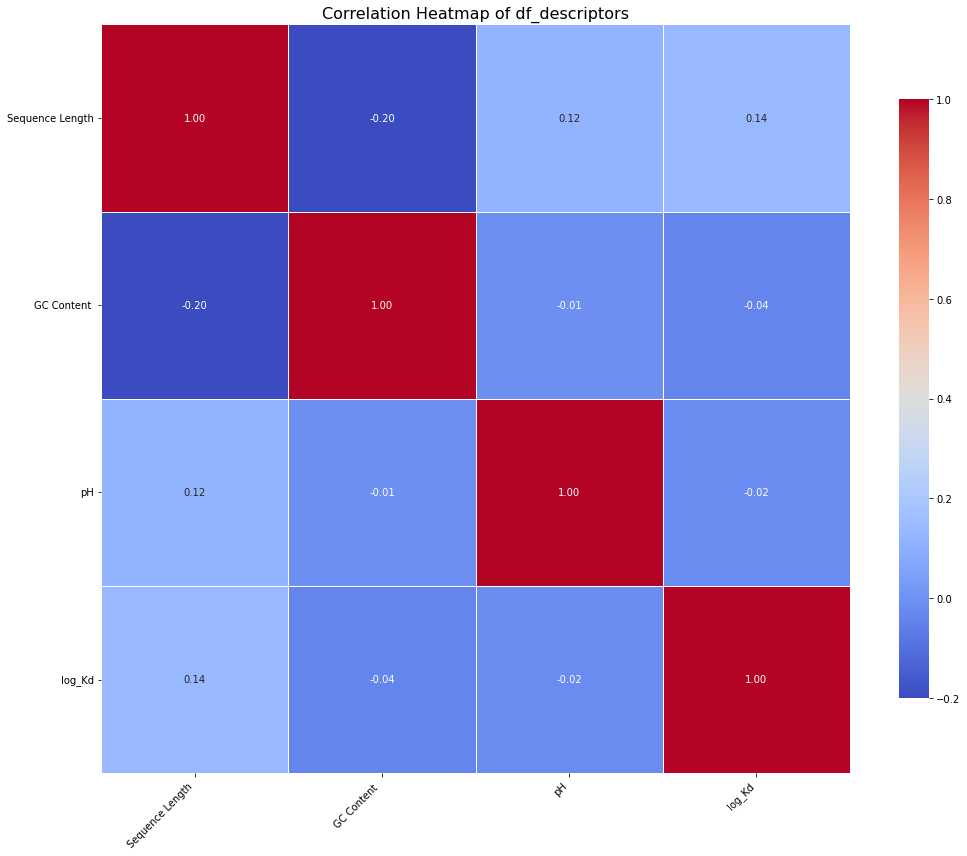

In [342]:
draw_heatmap(df.drop(['Type of Nucleic Acid', 'Aptamer Sequence', 'Kd (nM)', 'Type of the buffer'], axis=1))

# Feature engineering

### Объединяем всё в одну таблицу

In [343]:
df_descriptors_filtered = df_descriptors_filtered.reset_index().drop(columns='index')
df_descriptors_filtered.index

RangeIndex(start=0, stop=446, step=1)

In [344]:
pybiomed_prot_df = pybiomed_prot_df.reset_index().drop(columns='index')
pybiomed_prot_df.index

RangeIndex(start=0, stop=446, step=1)

In [345]:
full_df = pd.concat([df_descriptors_filtered, pybiomed_prot_df], axis=1)
full_df = full_df.loc[:, ~full_df.columns.duplicated(keep='first')]
full_df

,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,filtered_sequence,charge_at_ph,log_molecular_weight,_PolarizabilityC1,...,_PolarityC1,_PolarityC2,_NormalizedVDWVC2,_PolarizabilityT12,_SolventAccessibilityT12,_SecondaryStrT12,_SecondaryStrT13,_PolarityT12,_PolarityT13,_HydrophobicityT13
0,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,10.475489,0.286,...,0.354,0.188,0.341,0.212,0.300,0.257,0.257,0.153,0.124,0.218
1,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,10.475489,0.286,...,0.354,0.188,0.341,0.212,0.300,0.257,0.257,0.153,0.124,0.218
2,0.047368,46.075316,9.605870,0.252632,0.300000,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,7.075591,9.938508,0.300,...,0.347,0.200,0.395,0.302,0.275,0.217,0.217,0.143,0.085,0.201
3,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514,12.003261,0.290,...,0.323,0.236,0.393,0.277,0.305,0.253,0.212,0.159,0.104,0.227
4,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514,12.003261,0.290,...,0.323,0.236,0.393,0.277,0.305,0.253,0.212,0.159,0.104,0.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.051502,58.075751,5.063468,0.375536,0.253219,-0.823176,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,-19.531950,10.890256,0.309,...,0.281,0.258,0.444,0.284,0.340,0.215,0.245,0.176,0.108,0.288
442,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718,11.434552,0.286,...,0.368,0.230,0.390,0.265,0.276,0.240,0.241,0.155,0.088,0.214
443,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718,11.434552,0.286,...,0.368,0.230,0.390,0.265,0.276,0.240,0.241,0.155,0.088,0.214
444,0.068738,50.059520,6.400377,0.305085,0.283427,-0.364218,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-9.317211,11.674451,0.317,...,0.315,0.234,0.365,0.305,0.275,0.237,0.282,0.130,0.097,0.178


In [346]:
pybiomed_dna_df.reset_index().drop(columns='index')
pybiomed_dna_df.index

RangeIndex(start=0, stop=446, step=1)

In [347]:
full_df = pd.concat([full_df, pybiomed_dna_df], axis=1)
full_df

,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,filtered_sequence,charge_at_ph,log_molecular_weight,_PolarizabilityC1,...,DAC_44,DAC_49,DAC_51,DAC_62,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75
0,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,10.475489,0.286,...,-0.810,-0.268,0.183,-0.146,0.194,-0.206,0.047,-0.213,0.261,-0.168
1,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,10.475489,0.286,...,-1.791,-0.470,0.285,-0.263,0.326,-0.419,0.107,-0.726,0.394,-0.286
2,0.047368,46.075316,9.605870,0.252632,0.300000,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,7.075591,9.938508,0.300,...,-0.055,-0.014,0.192,0.099,0.058,-0.037,-0.001,0.052,0.105,0.085
3,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514,12.003261,0.290,...,0.018,-0.084,-0.020,-0.183,0.191,-0.083,-0.094,0.031,0.061,0.062
4,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514,12.003261,0.290,...,0.052,-0.117,-0.094,-0.117,-0.131,-0.084,-0.104,0.043,-0.092,-0.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.051502,58.075751,5.063468,0.375536,0.253219,-0.823176,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,-19.531950,10.890256,0.309,...,-0.025,0.170,-0.131,-0.054,0.034,0.025,0.127,0.069,0.045,0.021
442,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718,11.434552,0.286,...,0.040,0.027,-0.034,-0.002,-0.079,-0.047,0.093,-0.000,0.069,-0.157
443,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718,11.434552,0.286,...,0.003,0.094,-0.021,-0.002,0.006,-0.085,0.027,-0.003,-0.015,0.027
444,0.068738,50.059520,6.400377,0.305085,0.283427,-0.364218,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-9.317211,11.674451,0.317,...,0.240,0.032,0.158,-0.066,0.065,-0.028,-0.030,-0.012,0.051,0.016


In [348]:
df.columns

Index(['Type of Nucleic Acid', 'Aptamer Sequence', 'Sequence Length',
       'GC Content ', 'Kd (nM)', 'Type of the buffer', 'pH',
       'filtered_sequence', 'log_Kd'],
      dtype='object')

In [349]:
input_feutures_df = df[['Sequence Length', 'GC Content ', 'pH', 'Kd (nM)', 'log_Kd']]
input_feutures_df = input_feutures_df.reset_index().drop(columns='index')
input_feutures_df.index

RangeIndex(start=0, stop=446, step=1)

In [350]:
full_df = pd.concat([full_df, input_feutures_df], axis=1)
full_df

,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,filtered_sequence,charge_at_ph,log_molecular_weight,_PolarizabilityC1,...,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75,Sequence Length,GC Content,pH,Kd (nM),log_Kd
0,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,10.475489,0.286,...,-0.206,0.047,-0.213,0.261,-0.168,15,0.600000,7.4,112.500,4.722953
1,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,TSEDHFQPFFNEKTFGAGEADCGLRPLFEKKQVQDQTEKELFESYI...,5.212521,10.475489,0.286,...,-0.419,0.107,-0.726,0.394,-0.286,6,0.666667,7.4,112.500,4.722953
2,0.047368,46.075316,9.605870,0.252632,0.300000,-0.134737,MARHVFLTGPPGVGKTTLIHKASEVLKSSGVPVDGFYTEEVRQGGR...,7.075591,9.938508,0.300,...,-0.037,-0.001,0.052,0.105,0.085,42,0.595238,7.6,6000.000,8.699515
3,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514,12.003261,0.290,...,-0.083,-0.094,0.031,0.061,0.062,81,0.444444,8.0,1.000,0.000000
4,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...,18.925514,12.003261,0.290,...,-0.084,-0.104,0.043,-0.092,-0.048,53,0.471698,8.0,4.000,1.386294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,0.051502,58.075751,5.063468,0.375536,0.253219,-0.823176,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,-19.531950,10.890256,0.309,...,0.025,0.127,0.069,0.045,0.021,85,0.494118,7.4,12.800,2.549445
442,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718,11.434552,0.286,...,-0.047,0.093,-0.000,0.069,-0.157,79,0.544304,7.0,89.410,4.493233
443,0.118012,40.088211,5.361588,0.319255,0.286957,-0.375031,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...,-20.058718,11.434552,0.286,...,-0.085,0.027,-0.003,-0.015,0.027,80,0.612500,7.0,231.900,5.446306
444,0.068738,50.059520,6.400377,0.305085,0.283427,-0.364218,MGARPLTLLRALLLPLLAGAQAAIVFIKEPSSQDALQGRRALLRCE...,-9.317211,11.674451,0.317,...,-0.028,-0.030,-0.012,0.051,0.016,41,0.512195,7.4,0.800,-0.223144


In [351]:

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   aromaticity               446 non-null    float64
 1   instability_index         446 non-null    float64
 2   isoelectric_point         446 non-null    float64
 3   helix_fraction            446 non-null    float64
 4   turn_fraction             446 non-null    float64
 5   gravy                     446 non-null    float64
 6   filtered_sequence         446 non-null    object 
 7   charge_at_ph              446 non-null    float64
 8   log_molecular_weight      446 non-null    float64
 9   _PolarizabilityC1         446 non-null    float64
 10  _PolarizabilityC2         446 non-null    float64
 11  _PolarizabilityC3         446 non-null    float64
 12  _SolventAccessibilityC1   446 non-null    float64
 13  _SolventAccessibilityC3   446 non-null    float64
 14  _Secondary

In [352]:
full_df.to_csv('all_stupid_features.csv')

### Корреялции фич с таргетом

In [353]:
analysis_df = full_df.drop(['Aptamer Sequence', 'filtered_sequence'],axis=1).drop(['Kd (nM)'], axis=1)
analysis_df.head()

,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,charge_at_ph,log_molecular_weight,_PolarizabilityC1,_PolarizabilityC2,...,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75,Sequence Length,GC Content,pH,log_Kd
0,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,5.212521,10.475489,0.286,0.419,...,0.194,-0.206,0.047,-0.213,0.261,-0.168,15,0.600000,7.4,4.722953
1,0.107143,32.264643,8.781448,0.295455,0.275974,-0.518506,5.212521,10.475489,0.286,0.419,...,0.326,-0.419,0.107,-0.726,0.394,-0.286,6,0.666667,7.4,4.722953
2,0.047368,46.075316,9.605870,0.252632,0.300000,-0.134737,7.075591,9.938508,0.300,0.489,...,0.058,-0.037,-0.001,0.052,0.105,0.085,42,0.595238,7.6,8.699515
3,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,18.925514,12.003261,0.290,0.461,...,0.191,-0.083,-0.094,0.031,0.061,0.062,81,0.444444,8.0,0.000000
4,0.076710,38.542585,8.926180,0.325501,0.255701,-0.503455,18.925514,12.003261,0.290,0.461,...,-0.131,-0.084,-0.104,0.043,-0.092,-0.048,53,0.471698,8.0,1.386294


In [354]:
identify_correlations(analysis_df.drop('log_Kd',axis=1))
analysis_df = analysis_df.drop(['_SolventAccessibilityC1', '_SecondaryStrC1', '_SecondaryStrC3', '_PolarityC1'], axis=1)
analysis_df.describe()

Strong Positive Correlations (Threshold: 0.75):
_SolventAccessibilityC1 and gravy: 0.91
_SecondaryStrC1 and helix_fraction: 0.82
_SecondaryStrC3 and turn_fraction: 1.00
_PolarityC1 and gravy: 0.82
---

Strong Negative Correlations (Threshold: 0.75):

Moderate Positive Correlations (Threshold: 0.5):
charge_at_ph and isoelectric_point: 0.54
_PolarizabilityC1 and turn_fraction: 0.51
_PolarizabilityC2 and instability_index: 0.50
_SecondaryStrC2 and aromaticity: 0.59
_SecondaryStrC3 and _PolarizabilityC1: 0.51
_ChargeC1 and _PolarizabilityC3: 0.70
_ChargeC1 and _SecondaryStrC1: 0.52
_PolarityC1 and _SolventAccessibilityC1: 0.69
_PolarityC1 and _SecondaryStrC2: 0.51
_PolarityC2 and instability_index: 0.59
_PolarityC2 and _PolarizabilityC2: 0.64
_NormalizedVDWVC2 and helix_fraction: 0.55
_NormalizedVDWVC2 and _PolarizabilityC2: 0.74
_NormalizedVDWVC2 and _SecondaryStrC1: 0.51
_SolventAccessibilityT12 and _ChargeC1: 0.51
_PolarityT12 and _PolarizabilityC2: 0.66
_PolarityT12 and _PolarityC2: 0.

,aromaticity,instability_index,isoelectric_point,helix_fraction,turn_fraction,gravy,charge_at_ph,log_molecular_weight,_PolarizabilityC1,_PolarizabilityC2,...,DAC_64,DAC_65,DAC_72,DAC_73,DAC_74,DAC_75,Sequence Length,GC Content,pH,log_Kd
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,...,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,0.082621,40.168912,6.985834,0.313286,0.290058,-0.307888,-8.105081,10.446396,0.332457,0.430863,...,-0.039110,-0.029025,-0.003464,-0.007529,-0.011343,-0.006175,75.683857,0.528468,7.518692,3.339780
std,0.026988,13.240573,1.890534,0.063669,0.049836,0.446344,28.469371,0.848147,0.061751,0.056830,...,0.101998,0.115101,0.114632,0.158430,0.102626,0.115710,18.818138,0.069885,0.274372,3.169026
min,0.000000,-17.104348,4.137390,0.160000,0.125000,-1.241860,-233.128536,7.633063,0.176000,0.258000,...,-0.400000,-0.419000,-0.397000,-0.726000,-0.357000,-0.336000,6.000000,0.289474,5.000000,-6.803395
25%,0.062112,32.264643,5.339762,0.276978,0.253797,-0.560656,-9.784898,9.862392,0.290000,0.395000,...,-0.102500,-0.095750,-0.069000,-0.074750,-0.074750,-0.082750,70.000000,0.481593,7.400000,1.793834
50%,0.082143,40.351304,6.270841,0.311343,0.287037,-0.312351,-3.402211,10.409251,0.320000,0.434000,...,-0.047500,-0.026000,-0.007500,-0.015000,-0.006500,-0.013000,80.000000,0.529706,7.466744,3.597218
75%,0.101417,48.956946,8.859842,0.336391,0.318878,-0.123750,3.355861,10.968417,0.361000,0.460000,...,0.011000,0.049500,0.065500,0.045000,0.053000,0.054750,86.000000,0.576632,7.600000,4.653960
max,0.154867,76.896639,11.956323,0.684211,0.494624,1.149383,59.173212,13.102127,0.530000,0.632000,...,0.352000,0.514000,0.488000,1.487000,0.394000,0.465000,145.000000,0.780488,8.500000,18.749984


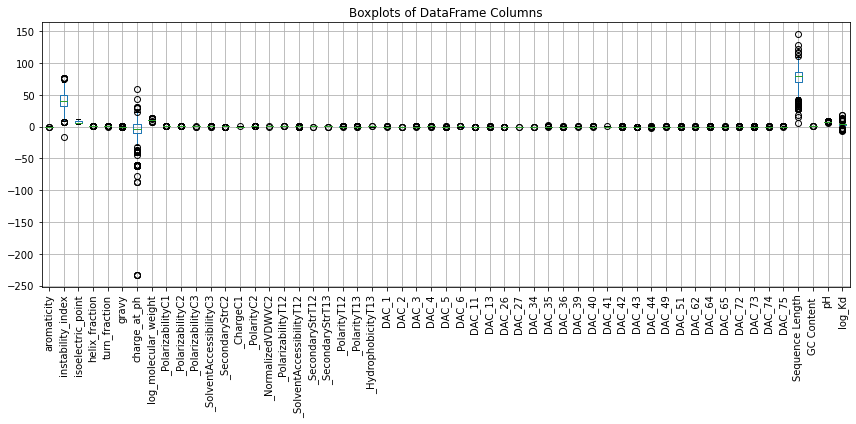

In [355]:
plot_boxplots(analysis_df)

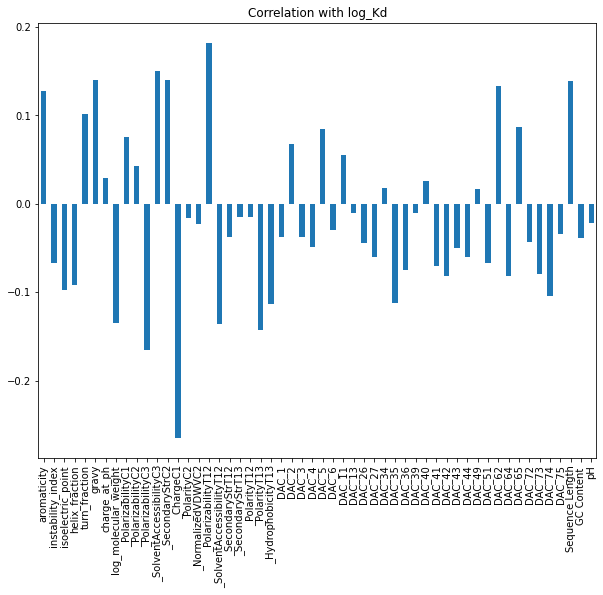

In [356]:
corr_matrix = analysis_df.corr()
plt.figure(figsize=(10, 8))
corr_matrix['log_Kd'].drop('log_Kd').plot(kind='bar')
plt.title('Correlation with log_Kd')
plt.show()

In [430]:
analysis_df['gravy'].corr(analysis_df['log_Kd'])

0.13987074345019468

### Выбор важных фич

In [560]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [561]:
df_selected_feautures = full_df.copy()

X = df_selected_feautures[['Sequence Length', 'GC Content ','_SolventAccessibilityC3', '_SolventAccessibilityT12', '_HydrophobicityT13', 'aromaticity'
,'helix_fraction','gravy', 'isoelectric_point','instability_index','turn_fraction','log_molecular_weight','_PolarizabilityC1']]
y = df_selected_feautures['log_Kd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [562]:
# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [563]:

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Создание объекта модели линейной регрессии
model = LinearRegression()

# Обучение модели на тренировочной выборке
model.fit(X_train_scaled, y_train)

# Предсказание значений для тестовой выборки
y_pred = model.predict(X_test_scaled)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Среднеквадратическая ошибка для тестовой выборки: 7.419
R квадрат для тестовой выборки: -0.033


In [564]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Создание объекта модели рандомного леса
model = RandomForestRegressor(max_depth=20, random_state=0)

# Обучение модели на тренировочной выборке
model.fit(X_train, y_train)

# Предсказание значений для тестовой выборки
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Среднеквадратическая ошибка для тестовой выборки: 3.744
R квадрат для тестовой выборки: 0.479


In [571]:
# Пробуем модель RandomForest с нормализованными-стандартизированными данными (скейлинг)

# Создание объекта модели рандомного леса
best_model = RandomForestRegressor(
    n_estimators=500,            # Количество деревьев
    max_depth=10,                # Максимальная глубина деревьев
    min_samples_split=7,         # Минимальное количество образцов для разделения узла
    min_samples_leaf=3,          # Минимальное количество образцов в листьях
    max_features='sqrt',         # Количество признаков для поиска наилучшего разбиения
    bootstrap=False,              # Использовать выборку с возвратом
    random_state=0)

# Обучение модели на тренировочной выборке
best_model.fit(X_train_scaled, y_train)

# Предсказание значений для тестовой выборки
y_pred = best_model.predict(X_test_scaled)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Среднеквадратическая ошибка для тестовой выборки: 3.275
R квадрат для тестовой выборки: 0.544


In [566]:
#Support Vector Machine
from sklearn.svm import SVR

# Создание объекта модели
model = SVR(kernel='rbf')

# Обучение модели
model.fit(X_train_scaled, y_train)

# Предсказание значений для тестовой выборки
y_pred = model.predict(X_test_scaled)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Среднеквадратическая ошибка для тестовой выборки: 5.776
R квадрат для тестовой выборки: 0.196


In [567]:
import xgboost as xgb

# Создание DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Задание параметров модели
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.1
}

# Обучение модели
model = xgb.train(params, dtrain, num_boost_round=100)

# Предсказание на тестовой выборке
y_pred = model.predict(dtest)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Среднеквадратическая ошибка для тестовой выборки: 4.607
R квадрат для тестовой выборки: 0.358


In [568]:
from catboost import CatBoostRegressor

# Создание и обучение модели CatBoost
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=9,
    l2_leaf_reg=0.1,
    loss_function='RMSE',
    verbose=100
)

model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

0:	learn: 3.0629834	total: 6.62ms	remaining: 6.61s
100:	learn: 0.5639402	total: 554ms	remaining: 4.93s
200:	learn: 0.4747401	total: 1.13s	remaining: 4.47s
300:	learn: 0.4689926	total: 1.68s	remaining: 3.89s
400:	learn: 0.4684373	total: 2.23s	remaining: 3.33s
500:	learn: 0.4683632	total: 2.8s	remaining: 2.79s
600:	learn: 0.4683540	total: 3.37s	remaining: 2.23s
700:	learn: 0.4683527	total: 3.94s	remaining: 1.68s
800:	learn: 0.4683525	total: 4.5s	remaining: 1.12s
900:	learn: 0.4683525	total: 5.06s	remaining: 556ms
999:	learn: 0.4683525	total: 5.63s	remaining: 0us
Среднеквадратическая ошибка для тестовой выборки: 3.494
R квадрат для тестовой выборки: 0.513


Fine-tuning of RandomForest

In [574]:
best_model

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
 min_samples_leaf=3, min_samples_split=7, n_estimators=500,
 random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestRegressor RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
 min_samples_leaf=3, min_samples_split=7, n_estimators=500,
 random_state=0)

In [576]:
# Подбор лучших параметров
from sklearn.model_selection import GridSearchCV

# Параметры для отбора
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

y_pred=grid_search.predict(X_test)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Elastic Net Regression (Best Params) - Mean Squared Error: {mse_best}')
print(f'Elastic Net Regression (Best Params) - R^2 Score: {r2_best}')

print(best_params)

Elastic Net Regression (Best Params) - Mean Squared Error: 3.5283741871695
Elastic Net Regression (Best Params) - R^2 Score: 0.5086307709526783
{'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [578]:
best_model

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
 random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestRegressor RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
 random_state=0)

In [579]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [583]:
import optuna

In [592]:
def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 20, step=5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)  # Corrected
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 7, step=2)  # Corrected
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create the model with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [593]:
# Run optimization
study = optuna.create_study(direction="minimize")  # Minimize MSE
study.optimize(objective, n_trials=100)  # Run 100 trials

[I 2024-07-19 22:12:34,424] A new study created in memory with name: no-name-ae66fda5-edf5-4f6d-8742-45897bc86b85
[I 2024-07-19 22:12:35,006] Trial 0 finished with value: 3.4407806426890684 and parameters: {'n_estimators': 300, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 3.4407806426890684.
[I 2024-07-19 22:12:35,483] Trial 1 finished with value: 4.574173545403511 and parameters: {'n_estimators': 200, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 3.4407806426890684.
[I 2024-07-19 22:12:36,876] Trial 2 finished with value: 4.451709228176389 and parameters: {'n_estimators': 700, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 3.4407806426890684.
[I 2024-07-19 22:12:37,339] Trial 3 finished with value: 3.1045001889267287 an

In [598]:
study.best_params

{'n_estimators': 100,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'bootstrap': False}

In [603]:
# Get the best model
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
 min_samples_leaf=3, min_samples_split=6, random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestRegressor RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
 min_samples_leaf=3, min_samples_split=6, random_state=42)

In [604]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print important metrics
print("Best Hyperparameters:", best_params)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Best Hyperparameters: {'n_estimators': 100, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False}
Mean Squared Error (MSE): 3.0155223535040983
R-squared (R2): 0.5800516568213142


In [605]:
best_model.feature_importances_

array([0.08715325, 0.03976789, 0.08436261, 0.08882651, 0.06856222,
 0.04976011, 0.05622572, 0.15030427, 0.05999293, 0.07673066,
 0.10023435, 0.07444353, 0.06363595])

На основании теста нескольких моделей с перебором параметров, было установлено, что наиболее оптимальной моделью для обучения оказался RandomForest, так как она быстрее обучалась по сравнению с остальными моделями и имела наименьшую среднеквадратическую ошибку (3.01) и наилучший коэффициент детерминации (0.58).Самой худшей моделью для обучения оказалась линейная регрессия (SME=7.419 и R^2=-0.033).

Теперь попробуем выявить feature importance с использованием базовой модели

In [606]:
import shap

In [607]:
explainer = shap.Explainer(model, X_train)

In [608]:
# Calculate SHAP values
shap_values = explainer(X_train)

 99%|===================| 353/356 [00:44<00:00]       

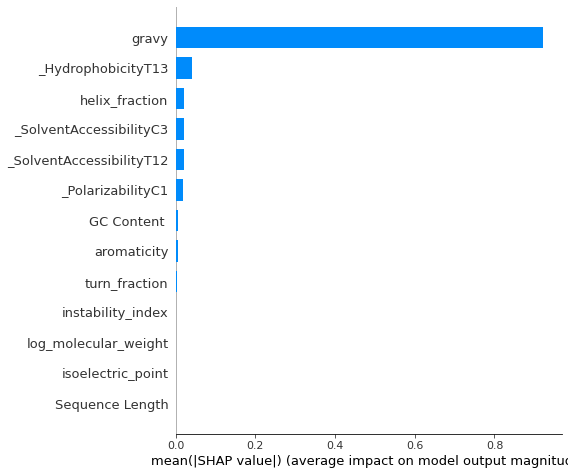

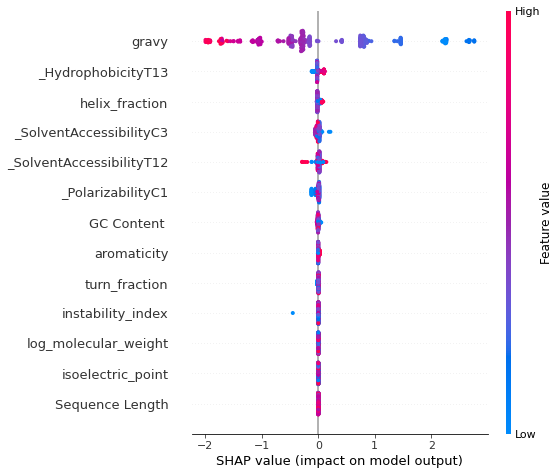

In [426]:
# Plot summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Detailed feature importance plot
shap.summary_plot(shap_values, X_train)

Feature importance с лучшей моделью

In [609]:
explainer = shap.Explainer(best_model, X_train)
# Calculate SHAP values
shap_values = explainer(X_train)

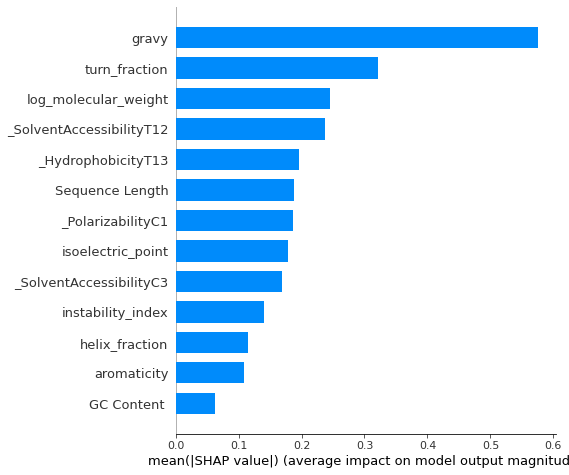

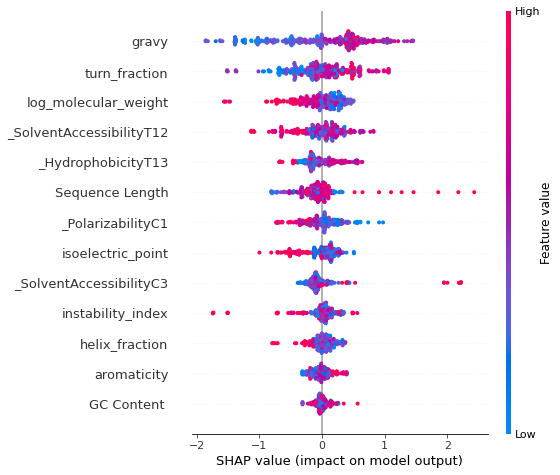

In [610]:
# Plot summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Detailed feature importance plot
shap.summary_plot(shap_values, X_train)

### Рассчёт новых фич

In [360]:
 #ДНК dG сворачивания днк (forgi), количество водородных связей в этой вторичной структуре (forgi)

#белок заряд белка от ph
!pip install --upgrade pip 
!pip install nupack

ERROR: Could not find a version that satisfies the requirement nupack (from versions: none)
ERROR: No matching distribution found for nupack


# Модели с полным набором фич

### PCA

In [520]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [521]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [522]:
for_pca_df = full_df.copy()

In [523]:
for_pca_df = for_pca_df.drop(columns=['Kd (nM)', 'filtered_sequence', 'Aptamer Sequence'])
X = for_pca_df.drop(columns=['log_Kd'])
y = for_pca_df['log_Kd']

In [524]:
# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [525]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [526]:
# Create a DataFrame with the principal components
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca_results = pd.DataFrame(data=X_pca, columns=pca_columns)

In [527]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

In [528]:
# Print the explained variance of each principal component
for i, ev in enumerate(explained_variance):
    print(f'Principal Component {i+1}: {ev*100:.2f}%')

Principal Component 1: 12.95%
Principal Component 2: 11.04%
Principal Component 3: 8.74%
Principal Component 4: 7.91%
Principal Component 5: 6.56%
Principal Component 6: 5.39%
Principal Component 7: 5.16%
Principal Component 8: 3.76%
Principal Component 9: 3.33%
Principal Component 10: 3.08%
Principal Component 11: 2.98%
Principal Component 12: 2.55%
Principal Component 13: 2.21%
Principal Component 14: 2.12%
Principal Component 15: 2.00%
Principal Component 16: 1.70%
Principal Component 17: 1.64%
Principal Component 18: 1.57%
Principal Component 19: 1.38%
Principal Component 20: 1.29%
Principal Component 21: 1.07%
Principal Component 22: 1.02%
Principal Component 23: 0.98%
Principal Component 24: 0.88%
Principal Component 25: 0.83%
Principal Component 26: 0.77%
Principal Component 27: 0.69%
Principal Component 28: 0.65%
Principal Component 29: 0.62%
Principal Component 30: 0.52%
Principal Component 31: 0.45%
Principal Component 32: 0.44%
Principal Component 33: 0.40%
Principal Compone

In [529]:
pd.concat([df_pca_results, y.reset_index(drop=True)], axis=1).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,log_Kd
0,3.751581,-0.739939,7.805496,-2.569495,3.947416,2.761957,-0.510266,5.865817,-2.485448,-0.272113,...,-0.065853,0.134624,0.059293,0.113986,-0.049180,-0.042508,-0.000110,-0.001940,0.001000,4.722953
1,7.069037,-5.003804,10.917964,-7.083891,6.665281,2.358197,-0.754885,11.887791,-3.283042,-0.486261,...,0.176631,0.342214,-0.016627,-0.194100,0.062481,-0.034938,-0.000644,-0.001875,-0.001469,4.722953
2,0.247722,0.084278,-1.450801,1.249504,0.531943,-1.553858,-0.053175,2.511236,0.932083,0.514553,...,0.315304,0.008000,-0.017541,-0.246527,0.058472,-0.032454,-0.003198,0.001043,0.000846,8.699515
3,3.046750,-0.808574,-2.307046,1.114662,0.128816,0.570962,-0.508325,1.498636,0.045514,0.088657,...,-0.111868,0.120709,-0.178651,0.071671,-0.013138,-0.028996,0.000497,-0.000731,0.003025,0.000000
4,3.659541,-1.464929,-1.941937,0.349364,0.829714,-1.133872,-1.220069,-0.104273,0.883146,0.722445,...,-0.184111,0.496778,-0.169468,0.014518,-0.034935,-0.036149,-0.005291,-0.002027,0.001875,1.386294


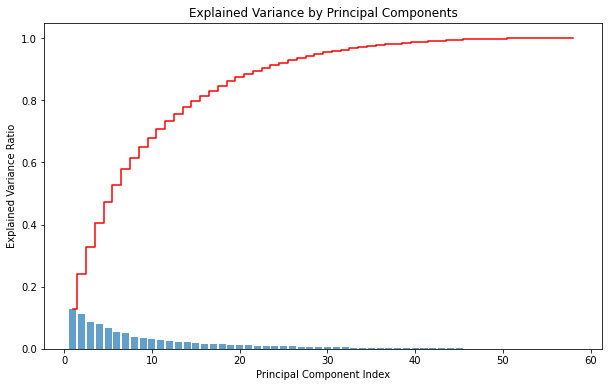

In [530]:
# Visualization of explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', color='red')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

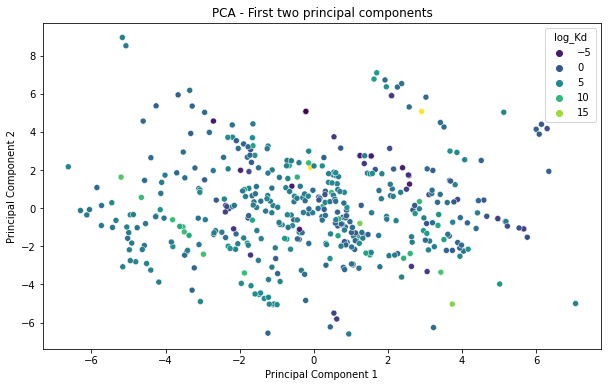

In [531]:
# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=y, palette='viridis', data=df_pca_results)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First two principal components')
plt.show()

### PCA + Linear Regression

In [532]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [533]:
# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression() In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LinearRegression LinearRegression()

In [534]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [535]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 8.877474548166607
R^2 Score: -0.23629683055786788


### L1 & L2 Regularization + Linear Regression

In [536]:
from sklearn.linear_model import Lasso, Ridge

In [537]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [538]:
# Standardize the predictors
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [539]:
# Train and evaluate Lasso regression
lasso = Lasso(alpha=1.0)  # You can tune the alpha parameter
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f'Lasso Regression - Mean Squared Error: {mse_lasso}')
print(f'Lasso Regression - R^2 Score: {r2_lasso}')

Lasso Regression - Mean Squared Error: 7.063385715466645
Lasso Regression - R^2 Score: 0.016337211032323107


In [540]:
# Train and evaluate Ridge regression
ridge = Ridge(alpha=1.0)  # You can tune the alpha parameter
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'Ridge Regression - Mean Squared Error: {mse_ridge}')
print(f'Ridge Regression - R^2 Score: {r2_ridge}')

Ridge Regression - Mean Squared Error: 7.096944212066497
Ridge Regression - R^2 Score: 0.011663780231752519


In [541]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [542]:
# Fine tune
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

In [543]:
elastic_net = ElasticNet()

In [544]:
# Perform Grid Search
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
 param_grid={'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
 'l1_ratio': [0.1, 0.5, 0.9]},
 scoring='r2') In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. GridSearchCV GridSearchCV(cv=5, estimator=ElasticNet(),
 param_grid={'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
 'l1_ratio': [0.1, 0.5, 0.9]},
 scoring='r2') estimator: ElasticNet ElasticNet() ElasticNet ElasticNet()

In [545]:
# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [546]:
# Evaluate best model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Elastic Net Regression (Best Params) - Mean Squared Error: {mse_best}')
print(f'Elastic Net Regression (Best Params) - R^2 Score: {r2_best}')

Elastic Net Regression (Best Params) - Mean Squared Error: 6.950722023943614
Elastic Net Regression (Best Params) - R^2 Score: 0.032027007042793154


In [547]:
print(best_params)

{'alpha': 0.1, 'l1_ratio': 0.1}


In [548]:
explainer = shap.Explainer(best_model, X_train)
# Calculate SHAP values
shap_values = explainer(X_train)

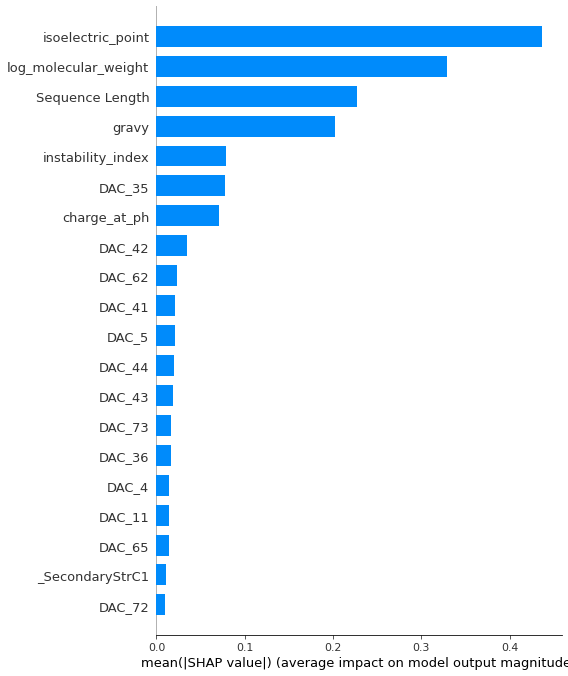

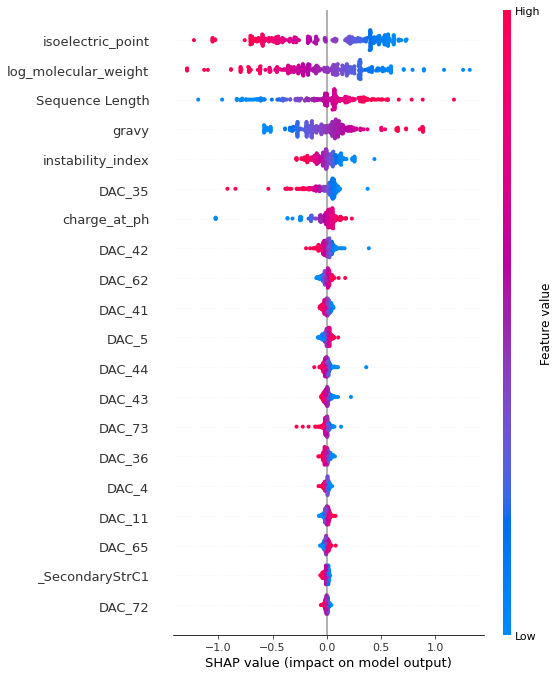

In [549]:
# Plot summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Detailed feature importance plot
shap.summary_plot(shap_values, X_train)

# Модели, комбинирующие важные фичи

In [612]:
df_selected_feautures = full_df.copy()

X = df_selected_feautures[[
    'Sequence Length', 'GC Content ','_SolventAccessibilityC3', '_SolventAccessibilityT12', '_HydrophobicityT13', 'aromaticity',
    'helix_fraction','gravy','instability_index','turn_fraction','log_molecular_weight','_PolarizabilityC1',
    'isoelectric_point', 'charge_at_ph', 'DAC_35'

]]
y = df_selected_feautures['log_Kd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

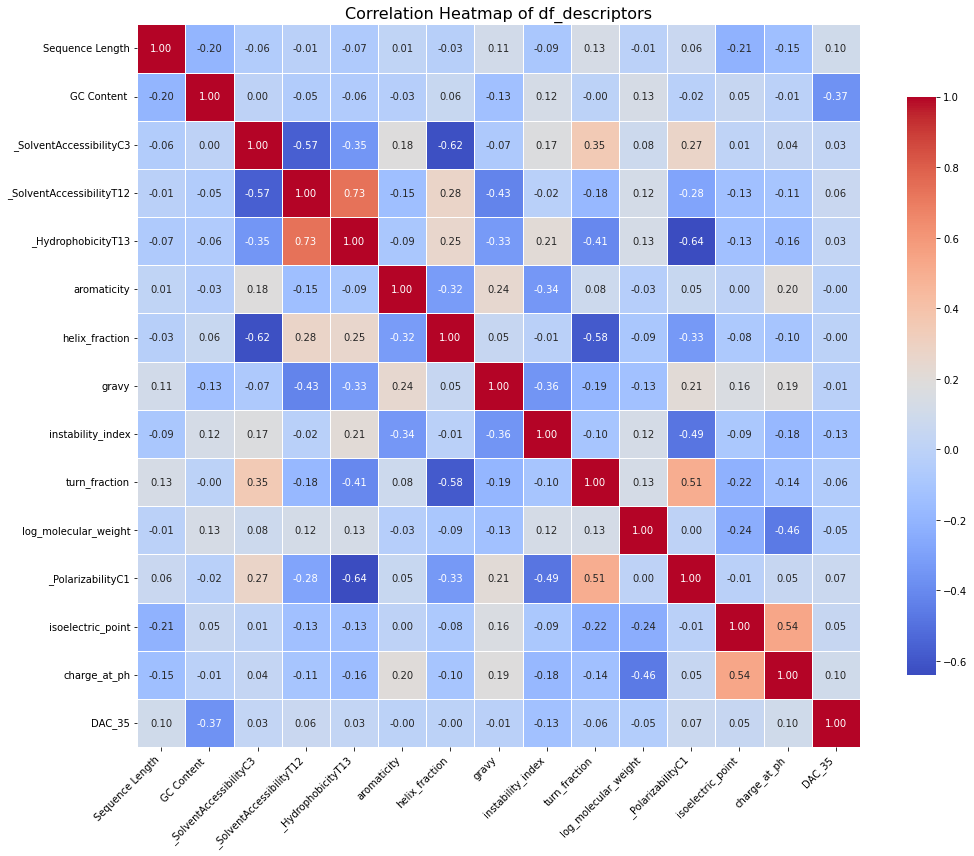

In [613]:
draw_heatmap(X)

In [614]:
# Создание объекта модели рандомного леса
best_model = RandomForestRegressor(
    n_estimators=500,            # Количество деревьев
    max_depth=10,                # Максимальная глубина деревьев
    min_samples_split=7,         # Минимальное количество образцов для разделения узла
    min_samples_leaf=3,          # Минимальное количество образцов в листьях
    max_features='sqrt',         # Количество признаков для поиска наилучшего разбиения
    bootstrap=False,              # Использовать выборку с возвратом
    random_state=0)

# Обучение модели на тренировочной выборке
best_model.fit(X_train_scaled, y_train)

# Предсказание значений для тестовой выборки
y_pred = best_model.predict(X_test_scaled)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

Среднеквадратическая ошибка для тестовой выборки: 3.275
R квадрат для тестовой выборки: 0.544


In [616]:
# Now fine-tuning + isoelectric point

def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 20, step=5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)  # Corrected
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 7, step=2)  # Corrected
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create the model with the suggested hyperparameters
    best_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # Train the model
    best_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [617]:
# Run optimization
study = optuna.create_study(direction="minimize")  # Minimize MSE
study.optimize(objective, n_trials=100)  # Run 100 trials

[I 2024-07-19 22:21:08,359] A new study created in memory with name: no-name-b5ce040e-9dd4-4dc6-86dc-0c4a6cef3a0c
[I 2024-07-19 22:21:09,398] Trial 0 finished with value: 3.493901878492852 and parameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 3.493901878492852.
[I 2024-07-19 22:21:09,751] Trial 1 finished with value: 3.493901878492852 and parameters: {'n_estimators': 200, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 0 with value: 3.493901878492852.
[I 2024-07-19 22:21:10,560] Trial 2 finished with value: 3.493901878492852 and parameters: {'n_estimators': 500, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 3.493901878492852.
[I 2024-07-19 22:21:10,738] Trial 3 finished with value: 3.493901878492852 and p

In [618]:
# Get the best model
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=500,
 random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestRegressor RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=500,
 random_state=42)

In [619]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print important metrics
print("Best Hyperparameters:", best_params)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Best Hyperparameters: {'n_estimators': 500, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Mean Squared Error (MSE): 3.346968376379679
R-squared (R2): 0.5338937472312815


# Выводы

### Лучшая модель
- Подходы с использованием сразу всех фич не дают ощутимого результата (PCA, regularization): MSE ≈ 7, R^2 ≈ 0
- Более эффективно выбрать около 10 нескоррелированных важных исходя из химической логики фич
- Лучшая модель - RandomForest, с использванием байесовской оптимизации гиперпараметров удалось получить MSE = 3.02 и R^2 = 0.58
- Однако и это не удовлетворительно, вся надежда на protein & DNA sequences embeddings + Deep Learning (в процессе)

### Наиболее важные фичи


log_molecular_weight, isoelectric point, gravy и sequence length.

- `Log_molecular_weight`: Отражает размер и сложность молекулы, что влияет на её взаимодействия.
- `Izoelectrical point`: Определяет заряд молекулы при разных pH, влияя на её растворимость и связывание.
- `Gravy`: Характеризует гидрофобность молекулы, что важно для её структурной стабильности и взаимодействий.
- `Sequence length`: Влияет на структурные особенности и количество возможных взаимодействий молекулы.
- Параметры DAC_35, DAC_62, DAC_41 и т.д. отражают физико-химические особенности днк-аптамера, рассчитанные на основе корелляций оснований с разными свойствами в его последовательности 

Эти параметры вместе дают всестороннее представление о физико-химических свойствах и поведении молекулы, что критично для точного предсказания Kd.